# MedEx Tag Extraction

MedEx is an system for extracting medication and signature information from clinical text developed by Hua Xu, Josh Denny, and Min Jiang at Vanderbilt University. We used MedEx-UIMA 1.3, the open source Java implementation of original Python MedEx based on the Unstructured Information Management Architecture (UIMA) framework, for semantic‐based parsing of drug names and signatures in clinical trials data. You can find more information about the MedEx tool at https://sbmi.uth.edu/ccb/resources/medex.htm. (Xu, et al., 2010)

Medicine data is one of the most important types of clinical data in electronic medical records, but it is often recorded in free-text notes. MedEx natural language processing tool exclusively extracts medication-related information. Not only does the MedEx system identifies drug and signature entities, it also codes the data into a standard representation that is easy to use for further processing.

MedEx is highly accurate on the drug information extraction. According to an evaluation processed with 826 documents in 2014, MedEx-UIMA system achieved F-measures of 98.5% and 97.5% respectively for encoding drug names to corresponding RxNorm generic drug ingredients, and F-measures of 85.4% and 88.1% respectively for mapping drug names/dose/form to the most specific RxNorm concepts. It also achieved an F-measure of 90.4% for normalizing frequency information to ISO standard. (Jiang, et al., 2014)


# One Active Ingredient, Many Drug Names

When a substance is first discovered, it is given a chemical name (eg. 5-amino-2-hydroxybenzoic acid) which describes its molecular structure. When a drug is approved by the FDA in the United States, it is assigned an official generic name and a proprietary brand name to be used exclusively by the company that requested approval for the drug. Ater the drug patent expires, other companies can manufacture and market the same drug by its generic name or create a new brand name. It is also possible for a patent drug produced by the a company to have multiple names in different countries. 

For example, an anti-diabetic drug has a global generic name "Acarbose". It is also known by the brand name "Prandase" in Canada, "Precose" in America, and "Glucobay" in Europe and China, all manufactured and sold by Bayer Pharmaceuticals. These 4 names refers to the same drug. 

When these 4 different names are processed by MedEx, they are all listed as "Acarbose" in the generic name field of MedEx processed output. MedEx also identifies the RxNorm CUI for the corresponding generic drug ingredients. It also identifies UMLS CUI code, however; in practice we found MedEx has a much higher probablity of identifying the RxNorm CUI.



References:

* Xu H, Stenner SP, Doan S, Johnson KB, Waitman LR, Denny JC. MedEx: a medication information extraction system for clinical narratives. J Am Med Inform Assoc. 2010 Jan-Feb;17(1):19–24.

* Xu H, Jiang M, Oetjens M, et al. Facilitating pharmacogenetic studies using electronic health records and natural-language processing: a case study of warfarin. J Am Med Inform Assoc. 2011 Jul-Aug;18(4):387–391.

* Jiang M, Wu Y, Shah A, Priyanka P, Denny JC, Xu H. Extracting and standardizing medication information in clinical text – the MedEx-UIMA system. AMIA Summits on Translational Science Proceedings. 2014;2014:37-42.

* "Generic Drugs" (http://www.fda.gov/downloads/Drugs/DevelopmentApprovalProcess/SmallBusinessAssistance/ucm127615.pdf), Center for Drug Evaluation and Research, U.S. Food and Drug Administration.

# Initial setup

Let's import the required libraries and set up global variables for the rest of the script.

In [79]:
# coding: utf-8
import os
import re
import pandas as pd
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Helper function to create a directory under the specified path, gracefully handling errors.

In [80]:
def __mkdir(*args):
    path = os.path.join(*args)
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
    return path

In [82]:
# Create the project directory holding the downloaded data, serialized dataframes and MetaMap install.
# Set working directory as the current directory of the ipython notebook
working_dir = os.getcwd()
data_dir = __mkdir(working_dir, "data","diab") # diabetes dataset
#data_dir = __mkdir(working_dir, "data") # seizure dataset
#print("Working directory: %s" % working_dir)

# MedEx Settings

We configure MedEx tagging settings here.

In [83]:
# medex input & output directory
medex_in = data_dir + "/medex_in/"
medex_out = data_dir + "/medex_out/"
keep_txt_files = True

medex_in, medex_out

('/Users/Lo/Work/CS109Project/data/diab/medex_in/',
 '/Users/Lo/Work/CS109Project/data/diab/medex_out/')

# Load data for MedEx processing

We use lemmatized criteria sentences from the filtered clinical trial results obtained in extract criteria step since all words were converted to a lower case standard format.

In [86]:
%time
criteria = pd.read_pickle(os.path.join(data_dir, 'ct_filtered.pckl'))
criteria.head()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


,Lemmas,NctId,Ngrams,Tags,Tokens,criteria_id
0,"[(Diagnosed, diagnose), (with, with), (type, t...",NCT00000620,"[((association, NNP), (guideline, NNS), (which...","[(Diagnosed, VBN), (with, IN), (type, NN), (2,...","[Diagnosed, with, type, 2, diabetes, mellitus,...",0
1,"[(For, for), (participants, participant), (age...",NCT00000620,"[((or, CC), (carotid, JJ), (revascularization,...","[(For, IN), (participants, NNS), (aged, VBD), ...","[For, participants, aged, 40, years, or, older...",1
2,"[(For, for), (participants, participant), (age...",NCT00000620,"[((be, VB), (at, IN), (high, JJ)), ((to, TO),)...","[(For, IN), (participants, NNS), (aged, VBD), ...","[For, participants, aged, 55, years, or, older...",2
3,"[(HbA1c, hba1c), (7, 7), (5, 5), (9, 9), (if, ...",NCT00000620,"[((5, CD), (9, CD), (if, IN)), ((on, IN), (mor...","[(HbA1c, NNP), (7, CD), (5, CD), (9, CD), (if,...","[HbA1c, 7, 5, 9, if, on, more, drugs, or, 7, 5...",3
4,"[(Subjects, subject), (selected, select), (for...",NCT00001165,"[((suspected, NNP), (abnormality, NNPS), (of, ...","[(Subjects, NNS), (selected, VBN), (for, IN), ...","[Subjects, selected, for, this, study, will, b...",4


# Preprocess the data by creating criteria text files

Create MedEx input files by exporting each criteria to a text file to "medex_in" directory.

In [87]:
def add_medex_prep(df, medex_in):
    for (cid, row) in zip(criteria.criteria_id, criteria.Lemmas):
        f = open(medex_in + "medex_" + str(cid) + ".txt", "w")
        for word in [k[1] for k in row]:
            f.write(word.encode('ascii', 'replace') + u' ')
        f.close()

add_medex_prep(criteria, medex_in)

# Process the data with MedEx

At this moment MedEx is ran in the system shell outside of the notebook.

Command Format (in MedEx installation folder):
$ java -Xmx1024m -cp lib/*:bin org.apache.medex.Main -i [input directory] -o [output directory]

# Parse MedEx data and write to criteria dataframe

For each line in the MedEx output files, the output includes all the drug signatures and their positions (start from 0). Fields are separated by "|".
		  
		  Sentence index (start from 1) 
		  Sentence text
		  Drug name      (e.g. 'simvastatin[0, 11]')
          Brand name     (e.g. 'zocor[12, 17]')
          Drug form      (e.g. 'tablet[19, 25]')
          Strength       (e.g. '10mg[20, 24]')
          Dose amount    (e.g. '2 tablets[2, 11]')
          Route          (e.g. 'by mouth[10, 18]')
          Frequency      (normalized frequency) (e.g. 'b.i.d.(R1P12H)[10, 16]', 
                          'R1P12H' is the TIMEX3 format of 'b.i.d.') 
          Duration       (e.g. 'for 10 days[10, 21]')
          Neccessity     (e.g. 'prn[10, 13]')
          UMLS CUI
          RXNORM RxCUI
          RXNORM RxCUI for generic name
		  Generic name   (associated with RXCUI code)

eg. 1	failed standard therapy i.e. refractory to corticotropin at least 40 iu/day for 14 day a follows persistent infantile spasm or recurrent spasm after discontinuation or taper or complication require dose modification|corticotropin[43,56]|||40iu[66,71]||||14 day[80,86]||C0985137|315719|376|corticotropin

We then extract MedEx terms from the Drug Name and the Generic Name field. Not every term MedEx extracted has a generic name -- for example, there is no generic name for the general drug types like "convulsants". In this case, Drug Name is extracted as the term. If a generic name exist, we use the generic name as the term, followed by alternative drug names in parenthesis. Drug signature positions are also removed from the data. 

MedEx reads all the files in the input folder, automatically splits text in the files into sentences, and export parsed results to the designated output folder, one drug on each row.

The data in other fields is not utilized at this moment, for they are too sparse to be effective in this small sample dataset. They would be useful when we work with a much greater number of clinical trials.

In [23]:
# parse medex output results, add column, delete the generated txt files
def create_medex_df(df, medex_in, medex_out, keeptxt=keep_txt_files):
    
    # remove empty output files
    for dirpath, dirs, files in os.walk(medex_out):
        for file in files: 
            path = os.path.join(dirpath, file)
            if os.stat(path).st_size == 0:
                os.remove(path)
                
    # read raw data in output txt files
    cid_list = []
    raw_drug_data = []
    for file in glob.glob(medex_out + "*.txt"):
        cid_list.append(int(file.split('/')[-1][6:-4])) # file # = criteria id
        
        with open (file, "r") as raw:
            raw_drug_data.append(raw.read().rstrip('\n'))
            
    # optional: delete all files under the input and output directories
    if not keeptxt:
        files = glob.glob(medex_out+'*') + glob.glob(medex_in+'*')
        for f in files:
            os.remove(f)
            
    processed = []
    for (count, i) in enumerate(raw_drug_data):
        for k in i.split('\n'):
            v = [re.sub(r'\[.+?\]\s*', '', j) for j in k.split('|')[1:]]
            v.append(cid_list[count])
            processed.append(v)
    medex_df = pd.DataFrame(processed, columns=['drug_name', 'brand_name', 'drug_form', 'strength', 'dose',
                                                'route', 'frequency', 'duration', 'neccessity', 'cui',
                                                'rxnorm_cui', 'rxnorm_cui_g', 'generic_name','criteria_id'])
    
    # additional filters/text modifications
    medex_df = medex_df.drop('brand_name', 1).drop('neccessity', 1)
    medex_df = medex_df[medex_df.drug_name!="refusal"][medex_df.drug_name!="timeline"][medex_df.drug_name!="impact"]
    medex_df['drug_name'] = medex_df['drug_name'].str.replace(' - ', '-')
    medex_df['drug_name'] = medex_df['drug_name'].str.replace(' -', '-')
    medex_df['drug_name'] = medex_df['drug_name'].str.replace(" ' ", "'")
    medex_df['generic_name'] = medex_df['generic_name'].str.replace(' \(obsolete\)', '')
    
    # converting plural tags to singular if the singular tag is also present in dataset
    to_replace = []
    checklist = list(medex_df.drug_name)+list(medex_df.generic_name)
    for i in medex_df.index:
        if str(medex_df.drug_name[i]).endswith("s"):
            if str(medex_df.drug_name[i])[:-1] in checklist:
                to_replace.append(medex_df.drug_name[i])
        if str(medex_df.generic_name[i]).endswith("s"):
            if str(medex_df.generic_name[i])[:-1] in checklist:
                to_replace.append(medex_df.generic_name[i])
    for i in set(to_replace):
        medex_df['drug_name'] = medex_df['drug_name'].str.replace(i, i[:-1])
        medex_df['generic_name'] = medex_df['generic_name'].str.replace(i, i[:-1])
    
    # merge with nctid/criteria id dataframe
    medex_df = pd.merge(df.loc[:, ['NctId', 'criteria_id']], medex_df, on='criteria_id', how='right')
    medex_df = medex_df.rename(columns={'NctId': 'nct_id'})
    
    # use generic name when possible as term column
    medex_df["term"] = np.where(medex_df['generic_name']=='', medex_df['drug_name'], medex_df['generic_name'])
    
    # add alternative names to terms
    to_replace = []
    for name, group in medex_df.groupby('term'):
        if len(set(group.drug_name))!=1 and len(name)!=0:
            other_names = []
            for i in set(group.drug_name):
                if name != i and ("/" not in i):
                    other_names.append(i)
            to_replace.append((name, name + " (" + ', '.join(str(e) for e in set(other_names)) +")"))
    for (j,k) in to_replace:
        medex_df['term'] = medex_df['term'].str.replace(j, k)    
    return medex_df
    
medex = create_medex_df(criteria.loc[:, ['NctId', 'criteria_id']], medex_in, medex_out)
medex.to_pickle(os.path.join(data_dir, 'medex.pckl'))

medex.head(10)

,nct_id,criteria_id,drug_name,drug_form,strength,dose,route,frequency,duration,cui,rxnorm_cui,rxnorm_cui_g,generic_name,term
0,NCT00001205,15,omeprazole,,,,oral,,,C1306417,393435,7646,omeprazole,omeprazole
1,NCT00001262,22,octreoscan,,,,,,,,228512,228512,octreoscan,octreoscan
2,NCT00001289,24,interferon alpha,,,,,,,,987700,987700,interferon alpha,interferon alpha
3,NCT00001912,101,prothrombin,,000ml,,,,,,8872,8872,factor ii (prothrombin),factor ii (prothrombin)
4,NCT00001912,104,vitamin c,,,,,,,C0003968,1151,1151,ascorbic acid (vit c),ascorbic acid (vit c)
5,NCT00001932,122,lactate,,,,,,,C0376261,114202,114202,lactate,lactate
6,NCT00001932,123,ifn,,,,,,two week,,1367185,1367185,interleukin-6,interleukin-6
7,NCT00003625,124,corticosteroid,,,,,,,,354,354,corticosteroid,corticosteroid
8,NCT00003625,125,investigational drug,,,,,,four week,C1875327,691729,691729,investigational drug,investigational drug
9,NCT00004399,144,albumin,,30mg,,,,24 hour,C0001924,433,433,albumin,albumin


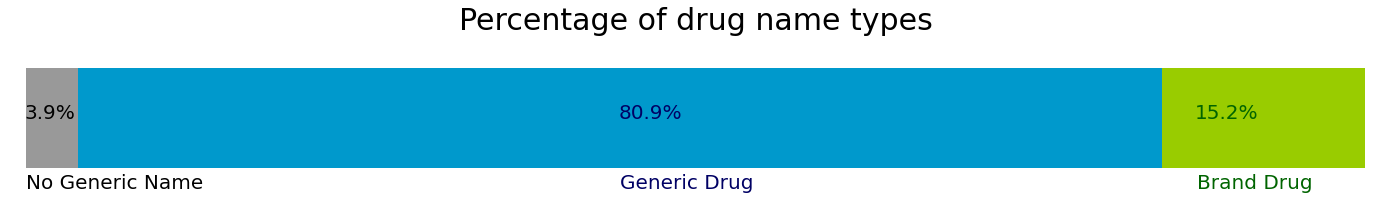

In [66]:
plt.figure(figsize=(24,3));
ax = plt.gca();
ax.grid(False);
ax.patch.set_visible(False);
plt.axis('off');
plt.plot([0, ngg], [5, 5], linewidth=100, linestyle="-", c="#999999",solid_capstyle="butt");
plt.plot([ngg, ngg+gd], [5, 5], linewidth=100, linestyle="-", c="#0099CC",solid_capstyle="butt");
plt.plot([ngg+gd, gd+ngg+ngd], [5, 5], linewidth=100, linestyle="-", c='#99CC00',solid_capstyle="butt");
plt.annotate(str(round(ngg*100,1))+"%", xy=(0,5),size=20)
plt.annotate(str(round(gd*100,1))+"%", xy=(ngg+gd/2,5),size=20,color='#000064')
plt.annotate(str(round(ngd*100,1))+"%", xy=(ngg+gd+ngd/2-0.05,5),size=20,color='#006400')
plt.annotate("No Generic Name", xy=(0,4.75),size=20)
plt.annotate("Generic Drug", xy=(ngg+gd/2,4.75),size=20,color='#000064')
plt.annotate("Brand Drug", xy=(ngg+gd+ngd/2-0.05,4.75),size=20,color='#006400')
plt.title("Percentage of drug name types", fontsize=30)